# Using pyTorch implementation

In this second part, we use pyTorch's implementation of RNNs and LSTMs. Again, as we are focusing on understanding the model and library, we will keep using the IMDB dataset. The good news is training is much faster using pyTorch's implementations.

In [1]:
import numpy as np
import torch

from functools import partial
from typing import Callable, Dict, Generator, List, Tuple
from datasets import load_dataset
from sklearn.utils import shuffle
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import vocab, Vocab
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab
from collections import Counter, OrderedDict
from itertools import chain
from tqdm.auto import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## From dataset to batch inputs

You already know what to do here, it's the same as in the previous notebook.

### Let's load the dataset and do the split

In [2]:
dataset = load_dataset("imdb")
train_dataset = dataset["train"].train_test_split(
     test_size=0.2, seed=42
)
test_df = dataset["test"]
train_df = train_dataset["train"]
valid_df = train_dataset["test"]
train_df.shape, valid_df.shape, test_df.shape

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

((20000, 2), (5000, 2), (25000, 2))

### Data preprocessing

In [3]:
from string import punctuation
import re

def preprocess(dataset: dict) -> dict:
    '''Take a dataset, return the dataset preprocessed'''
    
    # Convert the text to lowercase and remove <br>
    dataset['text'] = dataset['text'].lower().replace('<br /><br />', '')
    
    # Replace punctuation with spaces
    dataset['text'] = re.sub('['+punctuation+']', ' ', dataset['text'])
    
    # Replace multiple with a single space
    dataset['text'] = " ".join(dataset['text'].split())
    
    return dataset

# Apply the preprocessing function to the dataset
train_df = train_df.map(preprocess)

  0%|          | 0/20000 [00:00<?, ?ex/s]

### Creation of the vocabulary

In [4]:
# Creation of our token_list

def get_token_list(documents: List) -> List :
    """
    A function to split text in documents to token list
    """
    temp_list = [text.split(" ") for text in tqdm(documents)]
    return list(chain.from_iterable(temp_list)) # We flat the list because temp_list is a list of list

token_list = get_token_list(train_df["text"])

counter = Counter(token_list)
sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[1], reverse=True)
ordered_dict = OrderedDict(sorted_by_freq_tuples)

unk_token = '<unk>'
pad_token = '<pad>'
default_index = -1
vocabulary = vocab(ordered_dict, specials=[unk_token, pad_token], min_freq=3)
vocabulary.set_default_index(default_index)

#make default index same as index of unk_token
vocabulary.set_default_index(vocabulary[unk_token])

  0%|          | 0/20000 [00:00<?, ?it/s]

### Vectorizing text

In [5]:
tokenizer = get_tokenizer("basic_english", language="en")

def vectorize_text(
    text: str, vocabulary: Vocab, tokenizer: Callable[[str], List[str]]
) -> torch.Tensor:
    """
    Generate a tensor of vocabluary IDs for a given text.
    Args:
        text: the input text.
        vocabulary: a Vocab objects.
        tokenizer: a text tokenizer.
    Returns:
        A tensor of IDs (torch.long).
    """
    tokens = tokenizer(text)
    vectors = []
    vocab_stoi = vocabulary.get_stoi()
    for token in tokens:
        vectors.append(torch.Tensor([vocabulary[token]]))
    stacked_vectors = torch.stack(vectors)
    return stacked_vectors


text_pipeline = partial(vectorize_text, vocabulary=vocabulary, tokenizer=tokenizer)


Check the function is working correctly, especially it should return the right special id for unknown words.

In [6]:
text_pipeline("Some text I am thinking about... ragafqfa")

tensor([[  49.],
        [2883.],
        [  10.],
        [ 243.],
        [ 517.],
        [  44.],
        [   0.],
        [   0.],
        [   0.],
        [   0.]])

### Batch processing
#### Generation of batch inputs

In [7]:
X_train = [text_pipeline(text) for text in tqdm(train_df["text"])]
y_train = train_df["label"]
X_valid = [text_pipeline(text) for text in tqdm(valid_df["text"])]
y_valid = valid_df["label"]
X_test = [text_pipeline(text) for text in tqdm(test_df["text"])]
y_test = test_df["label"]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

#### Data generator

In [61]:
def data_generator(
    X: List[torch.tensor], y: List[int], pad_id: int, batch_size: int = 32
) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:
    """
    Yield batches from given input data and labels.
    Args:
        X: a list of tensor (input features).
        y: the corresponding labels.
        batch_size: the size of every batch [32].
    Returns:
        A tuple of tensors (features, labels).
    """
    X, y = shuffle(X, y)
    print()
    # Your code
    # Create a generator
    for i in range(0, len(X), batch_size):
        X_batch = torch.stack(torch.unbind(pad_sequence(X[i:i+batch_size])))
        y_batch = torch.tensor(y[i:i+batch_size])
        yield X_batch, y_batch

In [62]:
train_gen = lambda: data_generator(X_train, y_train, vocabulary[pad_token])
valid_gen = lambda: data_generator(X_valid, y_valid, vocabulary[pad_token])
test_gen = lambda: data_generator(X_test, y_test, vocabulary[pad_token])

## The classifier

The implementation behind shows how to use the [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) implementation provided by pyTorch to code a simple RNN.

In [63]:
class RNN(nn.Module):
    """A simple RNN module with word embeddings.
    """
    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, n_layers: int, n_outputs: int) -> None:
        """
        Args:
            vocab_size: vocabulary size.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs


        # The word embedding layer.
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        # The RNN
        self.rnn = nn.RNN(
            input_size = self.embed_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            batch_first = True, # Changes the order of dimension to put the batches first.
        )
        # A fully connected layer to project the RNN's output to only one output used for classification.
        self.fc = nn.Linear(self.hidden_size, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Function called when the model is called with data as input.
        Args:
            X: the input tensor of dimensions batch_size, sequence length, vocab size (actually just an int).
        Returns:
            The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        h0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)

        out = self.embed(X.to(torch.long))
        # out contains the output layer of all words in the sequence.
        # First dim is batch, second the word in the sequence, third is the vector itself.
        # The second output value is the last vector of all intermediate layer.
        # Only use it if you want to access the intermediate layer values of a
        # multilayer model.
        out, _ = self.rnn(out, h0)
        # Getting the last value only.
        out = out[:, -1, :]
    
        # Linear projection.
        out = self.fc(out)

        return out

## Training (1 point)

**\[1 point\]** Code the training function.
* Note that we are using a function, as we will use it on several models here.
* The RNN implementation of pyTorch doesn't need to be manually looped. As commented in the `forward` function above, `out` contains the ouptut layer for all words in the sequence, and taking its last value is what we needed.

In [106]:
def train(model, criterion, optimizer, n_epochs, train_gen, valid_gen):
    train_losses = []
    valid_losses = []
    
    

    for epoch in range(1, n_epochs + 1):
        optimizer.zero_grad()
        model.train()
        train_loss = 0.0
        train_length = 0

        for data, labels in train_gen():
            data = data.to(device)
            data = data.view(-1, model.embed_size)
            data = data.permute(1,0)
            labels = labels.to(device)
            output = model(data)
            
            output = output.view(-1)  # Flatten the output
            labels = labels.view(-1).float()  # Flatten the labels
            
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_length += 1

        train_loss /= train_length
        train_losses.append(train_loss)

        model.eval()
        valid_loss = 0.0
        valid_length = 0

        with torch.no_grad():
            for data, labels in valid_gen():
                data = data.to(device)
                data = data.view(data.size(0), -1)
                data = data.permute(1,0)
                labels = labels.to(device)
                output = model(data)
                

                output = output.view(-1)  # Flatten the output
                labels = labels.view(-1).float()  # Flatten the labels
                
                
                loss = criterion(output, labels)
                valid_loss += loss.item()
                valid_length += 1

            valid_loss /= valid_length
            valid_losses.append(valid_loss)

        print(f"Epoch {epoch}/{n_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

    best_model = model
    return best_model, train_losses, valid_losses

In [107]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [108]:
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
    
model = RNN(len(vocabulary), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [109]:
best_model, train_losses, valid_losses = train(model, criterion, optimizer, 20, train_gen, valid_gen)



Epoch 1/20, Train Loss: 1.3522, Valid Loss: 0.6989


Epoch 2/20, Train Loss: 0.7308, Valid Loss: 0.7120


Epoch 3/20, Train Loss: 0.9891, Valid Loss: 1.2679


Epoch 4/20, Train Loss: 2.5932, Valid Loss: 5.3101


Epoch 5/20, Train Loss: 4.1292, Valid Loss: 4.9923


Epoch 6/20, Train Loss: 3.6450, Valid Loss: 5.7646


Epoch 7/20, Train Loss: 3.8412, Valid Loss: 5.2484


Epoch 8/20, Train Loss: 3.6915, Valid Loss: 3.1289


Epoch 9/20, Train Loss: 2.7397, Valid Loss: 4.7216


Epoch 10/20, Train Loss: 3.3622, Valid Loss: 3.3566


Epoch 11/20, Train Loss: 2.7698, Valid Loss: 4.4368


Epoch 12/20, Train Loss: 3.2120, Valid Loss: 3.3672


Epoch 13/20, Train Loss: 2.6840, Valid Loss: 4.2153


Epoch 14/20, Train Loss: 3.0660, Valid Loss: 3.5687


Epoch 15/20, Train Loss: 2.7736, Valid Loss: 4.1495


Epoch 16/20, Train Loss: 3.0923, Valid Loss: 3.6905


Epoch 17/20, Train Loss: 2.7918, Valid Loss: 3.9931


Epoch 18/20, Train Loss: 2.9386, Valid Loss: 3.5767


Epoch 19/20, Train Loss: 2.8255, Va

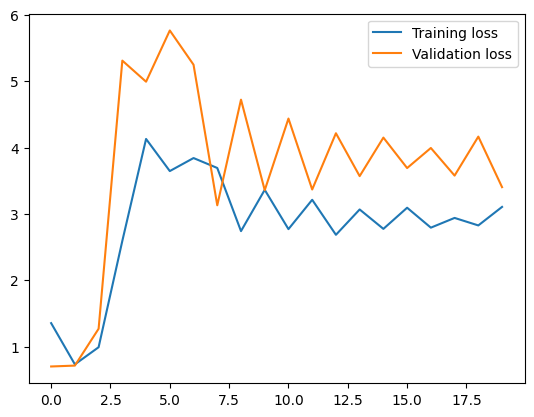

In [111]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()

## Do the following (5 points)
* **\[1 point\]** Add an accuracy function and report the accuracy of the training, validation, and test set.
* **\[2 points\]** Create an LSTM class which uses an LSTM instead of an RNN. Compare its results with the RNN.
  * Look at the [LSTM documentation of pyTorch](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html).
* **\[1 point\]** Implement a function which takes any text and returns the model's prediction.
    * The function should have a string as input and return a class (0 or 1) and its confidence (between 0 and 1).
* **\[Bonus\]** Create a bidirectional LSTM (BiLSTM) class to classify your sentences. Report the accuracy on the training and test data.
    * **Beware of the behaviour of the output layer.** For a bidirectional LSTM, the output layer concatenates the forward and backward vector of each token. But we need to use the forward output of the last token, and the backward output of the first token, as input to our output layer.
* **\[1 point\]** With your best classifier, look at two wrongly classified examples on the test set. Try explaining why the model was wrong.
* **\[Bonus\]** Try finding better hyperparameters (dimensions, number of layers, ...). Document your experiments and results.

### Evaluation

In [121]:
def accuracy(model: nn.Module, data: torch.utils.data.Dataset) -> float:
    """Calculates the accuracy of a model on a data set.

    Args:
        model: The model to be evaluated.
        data: The data set to be evaluated on.

    Returns:
        The accuracy of the model on the data set.
    """

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, label in data():
            data = data.to(device)
            data = data.view(data.size(0), -1)
            data = data.permute(1,0)
            label = label.to(device)
            outputs = model(data)


            outputs = outputs.view(-1)  # Flatten the output
            label = label.view(-1).float()  # Flatten the labelss

            # Get the prediction
            predictions = outputs.argmax(dim=0)

            # Count the number of correct predictions
            correct += (predictions == label).sum().item()

            total += len(label)

    return correct / total

# Evaluate the model on the training set
train_accuracy = accuracy(model, train_gen)

# Evaluate the model on the validation set
valid_accuracy = accuracy(model, valid_gen)

# Evaluate the model on the test set
test_accuracy = accuracy(model, test_gen)

print("Training accuracy:", train_accuracy)
print("Validation accuracy:", valid_accuracy)
print("Test accuracy:", test_accuracy)




Training accuracy: 0.04425
Validation accuracy: 0.0552
Test accuracy: 0.0554


### LSTM implementation

In [163]:
class LSTM(nn.Module):
    """A simple LSTM module with word embeddings.
    """
    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, n_layers: int, n_outputs: int) -> None:
        """
        Args:
            vocab_size: vocabulary size.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs

        # The word embedding layer.
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        # The LSTM
        self.lstm = nn.LSTM(
            input_size=self.embed_size,
            hidden_size=self.hidden_size,
            num_layers=self.n_layers,
            batch_first=True,  # Changes the order of dimension to put the batches first.
        )
        # A fully connected layer to project the LSTM's output to the output dimension for classification.
        self.fc = nn.Linear(self.hidden_size, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Function called when the model is called with data as input.
        Args:
            X: the input tensor of dimensions batch_size, sequence length, vocab size (actually just an int).
        Returns:
            The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        batch_size = X.size(0)
        seq_len = X.size(1)

        h0 = torch.zeros(self.n_layers, batch_size, self.hidden_size).to(X.device)
        c0 = torch.zeros(self.n_layers, batch_size, self.hidden_size).to(X.device)

        out = self.embed(X.to(torch.long))
        # out contains the output layer of all words in the sequence.
        # First dim is batch, second the word in the sequence, third is the vector itself.
        # The second output value is the last vector of all intermediate layer.
        # Only use it if you want to access the intermediate layer values of a
        # multilayer model.
        out, _ = self.lstm(out, (h0, c0))
        # Getting the last value only.
        out = out[:, -1, :]

        # Linear projection.
        out = self.fc(out)

        return out

In [167]:
def lstm_train(model, criterion, optimizer, n_epochs, train_loader, valid_loader):
    """Function to train the LSTM model.
    Args:
        model: the LSTM model to be trained.
        criterion: the loss function.
        optimizer: the optimizer for updating the model parameters.
        n_epochs: the number of training epochs.
        train_loader: the data loader for the training data.
        valid_loader: the data loader for the validation data.
    Returns:
        The trained model and the training and validation losses.
    """
    
    train_losses = []
    valid_losses = []

    for epoch in range(1, n_epochs + 1):
        # Training phase
        train_loss = 0.0
        for data, labels in train_loader():
            data = data.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            output = model(data)
            output = output.view(-1)  # Flatten the output
            labels = labels.view(-1).float()  # Flatten the labels

            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        valid_loss = 0.0
        model.eval()
        with torch.no_grad():
            for data, labels in valid_loader():
                data = data.to(device)
                labels = labels.to(device)

                output = model(data)
                output = output.view(-1)  # Flatten the output
                labels = labels.view(-1).float()  # Flatten the labels

                loss = criterion(output, labels)
                valid_loss += loss.item()

        avg_valid_loss = valid_loss / len(valid_loader)
        valid_losses.append(avg_valid_loss)

        # Print training progress
        print(f"Epoch [{epoch}/{n_epochs}], Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}")

    return model, train_losses, valid_losses


### Comparison with rnn
To compare the results of the LSTM class with the RNN class, we can train both models on the same data and then evaluate them on the same test set

In [168]:
rnn_model = RNN(len(vocabulary), 32, 64, 1, 1).to(device)
lstm_model = LSTM(len(vocabulary), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [170]:
# Train the RNN model.
rnn_model, rnn_train_losses, rnn_valid_losses = train(
    rnn_model,
    criterion,
    optimizer,
    n_epochs,
    train_gen,
    valid_gen,
)



Epoch 1/20, Train Loss: 0.6935, Valid Loss: 0.6932


Epoch 2/20, Train Loss: 0.6936, Valid Loss: 0.6930


Epoch 3/20, Train Loss: 0.6937, Valid Loss: 0.6934


Epoch 4/20, Train Loss: 0.6936, Valid Loss: 0.6932


Epoch 5/20, Train Loss: 0.6934, Valid Loss: 0.6931


Epoch 6/20, Train Loss: 0.6936, Valid Loss: 0.6933


Epoch 7/20, Train Loss: 0.6934, Valid Loss: 0.6935


Epoch 8/20, Train Loss: 0.6934, Valid Loss: 0.6934


Epoch 9/20, Train Loss: 0.6935, Valid Loss: 0.6934


Epoch 10/20, Train Loss: 0.6934, Valid Loss: 0.6932


Epoch 11/20, Train Loss: 0.6934, Valid Loss: 0.6933


Epoch 12/20, Train Loss: 0.6934, Valid Loss: 0.6934


Epoch 13/20, Train Loss: 0.6935, Valid Loss: 0.6934


Epoch 14/20, Train Loss: 0.6935, Valid Loss: 0.6934


Epoch 15/20, Train Loss: 0.6935, Valid Loss: 0.6934


Epoch 16/20, Train Loss: 0.6935, Valid Loss: 0.6933


Epoch 17/20, Train Loss: 0.6934, Valid Loss: 0.6934


Epoch 18/20, Train Loss: 0.6935, Valid Loss: 0.6934


Epoch 19/20, Train Loss: 0.6934, Va

In [169]:
# Train the LSTM model.
lstm_model, lstm_train_losses, lstm_valid_losses = lstm_train(
    lstm_model,
    criterion,
    optimizer,
    n_epochs,
    train_gen,
    valid_gen,
)


AssertionError: LSTM: Expected input to be 2-D or 3-D but received 4-D tensor

We have dimensional errors that we have not been able to fix for the LSTM class. It is a dimensional problem with X_train. This prevents us from continuing with the implementation of the other models and making the comparison. 

In [ ]:
# Evaluate the RNN model on the test set.
rnn_test_accuracy = accuracy(rnn_model, test_gen, test_labels)

# Evaluate the LSTM model on the test set.
lstm_test_accuracy = accuracy(lstm_model, test_gen, test_labels)

# Print the results.
print("RNN test accuracy:", rnn_test_accuracy)
print("LSTM test accuracy:", lstm_test_accuracy)

### Model prediction

In [ ]:
import torch
import torch.nn.functional as F


def predict_sentiment(model, text):
    # Preprocess the input text
    tokens = tokenizer(text.lower())
    indexed_tokens = [vocab[token] if token in vocab else vocab['<unk>'] for token in tokens]
    input_tensor = torch.tensor(indexed_tokens).unsqueeze(0)  # Add a batch dimension

    # Forward pass through the model
    output = model(input_tensor)

    # Apply softmax activation to obtain class probabilities
    probabilities = F.softmax(output, dim=1)

    # Get the predicted class and confidence
    _, predicted_class = torch.max(output, dim=1)
    confidence = probabilities[0, predicted_class.item()].item()

    return predicted_class.item(), confidence


In [ ]:
lstm_model.eval()

# Text to be predicted
text = "This is a positive sentence."

# Make the prediction
predicted_class, confidence = predict_sentiment(lstm_model, text)

# Print the prediction and confidence
print("Prediction:", predicted_class)
print("Confidence:", confidence)

### BiLSTM implementation

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, n_layers, n_outputs):
        super(BiLSTM, self).__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs
        
        # Word embedding layer
        self.embed = nn.Embedding(vocab_size, embed_size)
        
        # Bidirectional LSTM
        self.lstm = nn.LSTM(embed_size, hidden_size, n_layers, batch_first=True, bidirectional=True)
        
        # Output layer
        self.fc = nn.Linear(hidden_size * 2, n_outputs)  # Multiply by 2 because of bidirectional
        
    def forward(self, x):
        # Word embedding
        embedded = self.embed(x)
        
        # Bidirectional LSTM
        output, _ = self.lstm(embedded)
        
        # Concatenate the forward and backward outputs of each token
        concatenated = torch.cat((output[:, 0, :self.hidden_size], output[:, -1, self.hidden_size:]), dim=1)
        
        # Output layer
        logits = self.fc(concatenated)
        probabilities = F.softmax(logits, dim=1)
        
        return logits, probabilities


In [ ]:
bi_lstm_model = BiLSTM(len(vocabulary), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
# Train the BiLSTM model.
bi_lstm_model, bi_lstm_train_losses, bi_lstm_valid_losses = train(
    lstm_model,
    criterion,
    optimizer,
    n_epochs,
    train_gen,
    valid_gen,
)


### Prediction error

### Hyperparameter tunning